In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from deap import base, creator, tools, algorithms
import random
import numpy as np
import time
import matplotlib.pyplot as plt



In [ ]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Define multi-objective fitness to maximize accuracy, minimize complexity, and training time
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0, -1.0))  # Maximize accuracy, minimize complexity & time
creator.create("Individual", list, fitness=creator.FitnessMulti)

print("Environment setup complete.")

Environment setup complete.


In [ ]:
def load_data():
    print("Loading and preprocessing CIFAR-10 dataset...")
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Normalize pixel values to [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # Convert labels to one-hot encoding
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    # Split training data into training and validation sets
    val_split = 0.1
    num_sample = 1000
    x_train = x_train[:num_sample]
    y_train = y_train[:num_sample]
    val_size = int(len(x_train) * val_split)
    x_val, y_val = x_train[:val_size], y_train[:val_size]
    x_train, y_train = x_train[val_size:], y_train[val_size:]

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

# Load data
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data()
print("Data preparation complete.")


Loading and preprocessing CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Data preparation complete.


In [ ]:
print("Training data shape:", x_train.shape)
print("Validation data shape:", x_val.shape)
print("Test data shape:", x_test.shape)

Training data shape: (900, 32, 32, 3)
Validation data shape: (100, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In [ ]:
def generate_individual():
    layers = []
    num_layers = random.randint(2, 4)  # Random number of layers
    for _ in range(num_layers):
        layer_type = random.choice(['conv', 'dense'])
        if layer_type == 'conv':
            layers.append({
                'type': 'conv',
                'filters': random.choice([16, 32, 64, 128]),
                'activation': random.choice(['relu', 'tanh'])
            })
        elif layer_type == 'dense':
            layers.append({
                'type': 'dense',
                'units': random.choice([64, 128, 256, 512]),
                'activation': random.choice(['relu', 'tanh'])
            })
    return layers

# Register individual and population in the DEAP toolbox
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, generate_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

print("Initial population generation complete.")


Initial population generation complete.


In [ ]:
def create_cnn(architecture):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(32, 32, 3)))  # Input layer for CIFAR-10

    added_flatten = False
    for layer in architecture:
        if layer['type'] == 'conv' and not added_flatten:
            model.add(tf.keras.layers.Conv2D(layer['filters'], (3, 3), activation=layer['activation'], padding='same'))
            model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        elif layer['type'] == 'dense':
            if not added_flatten:
                model.add(tf.keras.layers.Flatten())
                added_flatten = True
            model.add(tf.keras.layers.Dense(layer['units'], activation=layer['activation']))

    if not added_flatten:
        model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

evaluation_counter = 1

def evaluate_cnn(individual):
    global evaluation_counter  # Use global counter to label individuals
    print(f"Evaluating individual {evaluation_counter}: {individual}")
    evaluation_counter += 1

    model = create_cnn(individual)
    start_time = time.time()

    # Train the model on a small subset for quicker evaluation
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        epochs=5, batch_size=32, verbose=False)
    accuracy = model.evaluate(x_val, y_val, verbose=0)[1]
    model_complexity = model.count_params()
    training_time = time.time() - start_time

    print(f"Individual {evaluation_counter - 1} Results: Accuracy: {accuracy}, Model Complexity: {model_complexity}, Training Time: {training_time}")
    return accuracy, model_complexity, training_time

# Register evaluation function in DEAP toolbox
toolbox.register("evaluate", evaluate_cnn)


In [ ]:
def lexicase_selection(population, k):
    selected = []
    for _ in range(k):
        candidates = population[:]
        random.shuffle(candidates)
        objectives = list(range(len(population[0].fitness.values)))
        random.shuffle(objectives)
        for obj in objectives:
            best_candidates = [c for c in candidates if c.fitness.values[obj] == max(c.fitness.values[obj] for c in candidates)]
            print("Best candidates:", best_candidates)  # Print best candidates for debugging
            candidates = best_candidates
            if len(candidates) == 1:
                break
        selected.append(candidates[0])
    return selected

# Register selection methods without specifying k
toolbox.register("select_tournament", tools.selTournament, tournsize=3)
toolbox.register("select_lexicase", lexicase_selection)

print("Lexicase selection setup complete.")

Lexicase selection setup complete.


In [ ]:
def apply_crossover_and_mutation(offspring, cxpb, mutpb):
    print("\n--- Applying Crossover and Mutation ---")

    # Apply crossover
    for i, (child1, child2) in enumerate(zip(offspring[::2], offspring[1::2]), start=1):
        if random.random() < cxpb:
            print(f"\nCrossover Pair {i}:")
            print(f"  Before Crossover:")
            print(f"    Child 1: {child1}")
            print(f"    Child 2: {child2}")

            # Perform crossover
            toolbox.mate(child1, child2)

            print(f"  After Crossover:")
            print(f"    Child 1: {child1}")
            print(f"    Child 2: {child2}")

            # Reset fitness after crossover
            del child1.fitness.values
            del child2.fitness.values

    # Apply mutation
    for i, mutant in enumerate(offspring, start=1):
        if random.random() < mutpb:
            print(f"\nMutation for Offspring {i}:")
            print(f"  Before Mutation: {mutant}")

            # Perform mutation
            toolbox.mutate(mutant)

            print(f"  After Mutation: {mutant}")

            # Reset fitness after mutation
            del mutant.fitness.values

    print("\n--- Crossover and Mutation Complete ---")


In [ ]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)

Iterative evolution process setup complete.

-- Generation 0 --
Evaluating individual 1: [{'type': 'dense', 'units': 512, 'activation': 'tanh'}, {'type': 'dense', 'units': 128, 'activation': 'tanh'}, {'type': 'dense', 'units': 256, 'activation': 'relu'}, {'type': 'dense', 'units': 512, 'activation': 'relu'}]
Individual 1 Results: Accuracy: 0.12999999523162842, Model Complexity: 1808778, Training Time: 4.867716312408447
Evaluating individual 2: [{'type': 'dense', 'units': 64, 'activation': 'tanh'}, {'type': 'conv', 'filters': 64, 'activation': 'tanh'}, {'type': 'dense', 'units': 64, 'activation': 'relu'}]
Individual 2 Results: Accuracy: 0.1599999964237213, Model Complexity: 201482, Training Time: 4.440538167953491
Evaluating individual 3: [{'type': 'conv', 'filters': 128, 'activation': 'relu'}, {'type': 'conv', 'filters': 16, 'activation': 'tanh'}]
Individual 3 Results: Accuracy: 0.3100000023841858, Model Complexity: 32282, Training Time: 4.823545217514038
Evaluating individual 4: [{'ty

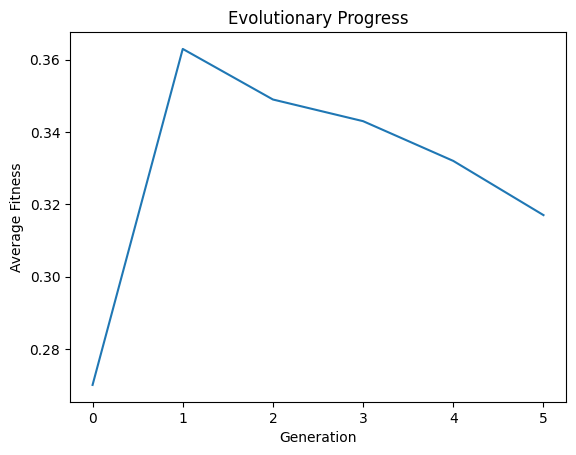

Best architecture found: [{'type': 'conv', 'filters': 64, 'activation': 'tanh'}, {'type': 'dense', 'units': 512, 'activation': 'relu'}, {'type': 'dense', 'units': 128, 'activation': 'tanh'}]


In [ ]:
def evolutionary_algorithm(n_gen=6, pop_size=10, cxpb=0.7, mutpb=0.5):
    global evaluation_counter  # Use global evaluation counter
    population = toolbox.population(n=pop_size)
    fitness_log = []

    for gen in range(n_gen):
        print(f"\n-- Generation {gen} --")

        # Reset evaluation counter at the start of each generation
        evaluation_counter = 1

        # Evaluate fitness of the population
        fitnesses = list(map(toolbox.evaluate, population))
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        # Calculate average fitness for logging
        avg_fitness = np.mean([ind.fitness.values[0] for ind in population])
        fitness_log.append(avg_fitness)
        print(f"Average Fitness: {avg_fitness}")

        # Selection of parents
        if gen < n_gen // 2:
            selected_parents = toolbox.select_tournament(population, len(population))
            print(f"Tournament selection in Generation {gen}:")
        else:
            selected_parents = toolbox.select_lexicase(population, len(population))
            print(f"Lexicase selection in Generation {gen}:")

        # Print selected parents' architectures and fitness with parent ID
        for idx, parent in enumerate(selected_parents):
            print(f"Selected Parent {idx + 1}: Architecture: {parent}, Fitness: {parent.fitness.values}")

        # Clone the selected parents to create offspring
        offspring = list(map(toolbox.clone, selected_parents))

        # Apply crossover and mutation to the offspring
        apply_crossover_and_mutation(offspring, cxpb, mutpb)

        # Replace the old population with the new offspring
        population[:] = offspring

    # Plotting the fitness progression
    plt.plot(range(n_gen), fitness_log)
    plt.xlabel('Generation')
    plt.ylabel('Average Fitness')
    plt.title('Evolutionary Progress')
    plt.show()

    # Return the best individual found
    best_ind = tools.selBest(population, 1)[0]
    return best_ind

# Run the modified evolutionary algorithm
print("Iterative evolution process setup complete.")
best_architecture = evolutionary_algorithm()
print("Best architecture found:", best_architecture)

Iterative evolution process setup complete.

-- Generation 0 --
Evaluating individual 1: [{'type': 'dense', 'units': 256, 'activation': 'relu'}, {'type': 'dense', 'units': 64, 'activation': 'tanh'}, {'type': 'dense', 'units': 256, 'activation': 'tanh'}, {'type': 'conv', 'filters': 64, 'activation': 'relu'}]
Individual 1 Results: Accuracy: 0.2199999988079071, Model Complexity: 822346, Training Time: 3.9800376892089844
Evaluating individual 2: [{'type': 'dense', 'units': 512, 'activation': 'relu'}, {'type': 'conv', 'filters': 64, 'activation': 'tanh'}, {'type': 'conv', 'filters': 16, 'activation': 'tanh'}]
Individual 2 Results: Accuracy: 0.27000001072883606, Model Complexity: 1578506, Training Time: 3.7273809909820557
Evaluating individual 3: [{'type': 'conv', 'filters': 128, 'activation': 'relu'}, {'type': 'dense', 'units': 512, 'activation': 'relu'}, {'type': 'conv', 'filters': 128, 'activation': 'relu'}]
Individual 3 Results: Accuracy: 0.36000001430511475, Model Complexity: 16786442, 

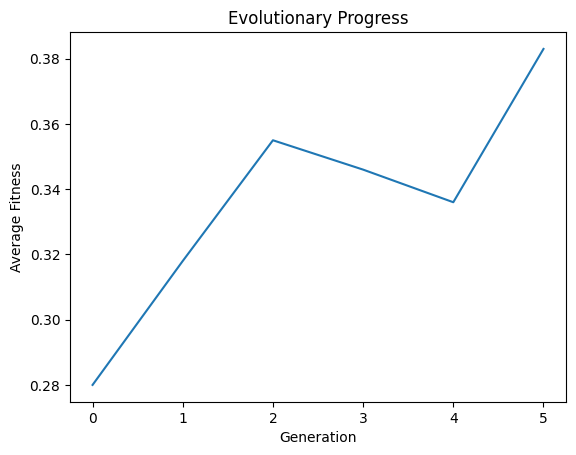

Best architecture found: [{'type': 'conv', 'filters': 64, 'activation': 'tanh'}, {'type': 'conv', 'filters': 128, 'activation': 'tanh'}, {'type': 'dense', 'units': 256, 'activation': 'relu'}, {'type': 'dense', 'units': 256, 'activation': 'relu'}]


In [ ]:
def evolutionary_algorithm(n_gen=6, pop_size=10, cxpb=0.7, mutpb=0.2):
    global evaluation_counter  # Use global evaluation counter
    population = toolbox.population(n=pop_size)
    fitness_log = []

    for gen in range(n_gen):
        print(f"\n-- Generation {gen} --")

        # Reset evaluation counter at the start of each generation
        evaluation_counter = 1

        # Evaluate fitness of the population
        fitnesses = list(map(toolbox.evaluate, population))
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        # Calculate average fitness for logging
        avg_fitness = np.mean([ind.fitness.values[0] for ind in population])
        fitness_log.append(avg_fitness)
        print(f"Average Fitness: {avg_fitness}")

        # Selection of parents
        if gen < n_gen // 2:
            selected_parents = toolbox.select_tournament(population, len(population))
            print(f"Tournament selection in Generation {gen}:")
        else:
            selected_parents = toolbox.select_lexicase(population, len(population))
            print(f"Lexicase selection in Generation {gen}:")

        # Print selected parents' architectures and fitness with parent ID
        for idx, parent in enumerate(selected_parents):
            print(f"Selected Parent {idx + 1}: Architecture: {parent}, Fitness: {parent.fitness.values}")

        # Clone the selected parents to create offspring
        offspring = list(map(toolbox.clone, selected_parents))

        # Apply crossover and mutation to the offspring
        apply_crossover_and_mutation(offspring, cxpb, mutpb)

        # Replace the old population with the new offspring
        population[:] = offspring

    # Plotting the fitness progression
    plt.plot(range(n_gen), fitness_log)
    plt.xlabel('Generation')
    plt.ylabel('Average Fitness')
    plt.title('Evolutionary Progress')
    plt.show()

    # Return the best individual found
    best_ind = tools.selBest(population, 1)[0]
    return best_ind

# Run the modified evolutionary algorithm
print("Iterative evolution process setup complete.")
best_architecture = evolutionary_algorithm()
print("Best architecture found:", best_architecture)

Iterative evolution process setup complete.

-- Generation 0 --
Evaluating individual 1: [{'type': 'conv', 'filters': 16, 'activation': 'tanh'}, {'type': 'conv', 'filters': 32, 'activation': 'relu'}, {'type': 'conv', 'filters': 16, 'activation': 'tanh'}, {'type': 'conv', 'filters': 16, 'activation': 'relu'}]
Individual 1 Results: Accuracy: 0.23999999463558197, Model Complexity: 12682, Training Time: 9.546576261520386
Evaluating individual 2: [{'type': 'conv', 'filters': 16, 'activation': 'relu'}, {'type': 'dense', 'units': 128, 'activation': 'tanh'}]
Individual 2 Results: Accuracy: 0.3199999928474426, Model Complexity: 526154, Training Time: 6.53222918510437
Evaluating individual 3: [{'type': 'dense', 'units': 64, 'activation': 'relu'}, {'type': 'dense', 'units': 256, 'activation': 'tanh'}, {'type': 'conv', 'filters': 32, 'activation': 'tanh'}, {'type': 'conv', 'filters': 16, 'activation': 'tanh'}]
Individual 3 Results: Accuracy: 0.25999999046325684, Model Complexity: 215882, Training 

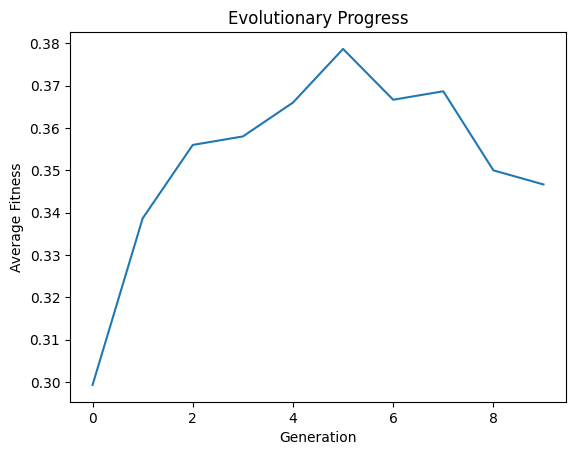

Best architecture found: [{'type': 'conv', 'filters': 64, 'activation': 'relu'}, {'type': 'dense', 'units': 256, 'activation': 'relu'}, {'type': 'dense', 'units': 256, 'activation': 'relu'}]


In [ ]:
def evolutionary_algorithm(n_gen=10, pop_size=15, cxpb=0.7, mutpb=0.2):
    global evaluation_counter  # Use global evaluation counter
    population = toolbox.population(n=pop_size)
    fitness_log = []

    for gen in range(n_gen):
        print(f"\n-- Generation {gen} --")

        # Reset evaluation counter at the start of each generation
        evaluation_counter = 1

        # Evaluate fitness of the population
        fitnesses = list(map(toolbox.evaluate, population))
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        # Calculate average fitness for logging
        avg_fitness = np.mean([ind.fitness.values[0] for ind in population])
        fitness_log.append(avg_fitness)
        print(f"Average Fitness: {avg_fitness}")

        # Selection of parents
        if gen < n_gen // 2:
            selected_parents = toolbox.select_tournament(population, len(population))
            print(f"Tournament selection in Generation {gen}:")
        else:
            selected_parents = toolbox.select_lexicase(population, len(population))
            print(f"Lexicase selection in Generation {gen}:")

        # Print selected parents' architectures and fitness with parent ID
        for idx, parent in enumerate(selected_parents):
            print(f"Selected Parent {idx + 1}: Architecture: {parent}, Fitness: {parent.fitness.values}")

        # Clone the selected parents to create offspring
        offspring = list(map(toolbox.clone, selected_parents))

        # Apply crossover and mutation to the offspring
        apply_crossover_and_mutation(offspring, cxpb, mutpb)

        # Replace the old population with the new offspring
        population[:] = offspring

    # Plotting the fitness progression
    plt.plot(range(n_gen), fitness_log)
    plt.xlabel('Generation')
    plt.ylabel('Average Fitness')
    plt.title('Evolutionary Progress')
    plt.show()

    # Return the best individual found
    best_ind = tools.selBest(population, 1)[0]
    return best_ind

# Run the modified evolutionary algorithm
print("Iterative evolution process setup complete.")
best_architecture = evolutionary_algorithm()
print("Best architecture found:", best_architecture)